In [4]:
import neo
import numpy as np
import random
import quantities as pq
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.cluster import DBSCAN
import os
import sys
sys.path.append('../pipeline/')
from settings import output_path
data_path = os.path.join(output_path, 'stage03_trigger_detection', 'trigger_times.nix')

In [5]:
with neo.NixIO(data_path) as io:
        block = io.read_block()

asig = block.segments[0].analogsignals[0]
evts = [ev for ev in block.segments[0].events if ev.name== 'Transitions'][0]
evts = evts.time_slice(t_start=0*pq.s, t_stop=10*pq.s)

## Separating Waves by Density Clustering
The slow wave activity we investigate lives in the 2D plane of the measurement interface, either the contact of the electrode array or the focal plane of the imaging device. The activity data obtained this way has an additional temporal compoment, and within this data we detect UP-transitions indicating wavefronts which propagate through space and time. A wavefront is detected as many adjacent UP-transitions which evolve coherently in time. Thus, in order to group together the many UP-transitions of one travelling wavefront and separate it from other wavefronts, we choose a density based clustering algorithm [(Ester et al. 1996)](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf).

This approach requires three parameters:
* a factor to transform the time dimension into a third space dimension
* the maximum distance between points to be considered neighbours
* the minimum number of points in a cluster

In [6]:
time_dim = 100
neighbour_distance = 18
min_samples = 20

up_idx = np.where(evts.labels == 'UP'.encode('UTF-8'))[0]

triggers = np.zeros((len(up_idx), 3))
triggers[:,2] = evts.times[up_idx] * time_dim
for i, channel in enumerate(evts.array_annotations['channels'][up_idx]):
    triggers[i][0] = asig.array_annotations['x_coords'][int(channel)]
    triggers[i][1] = asig.array_annotations['y_coords'][int(channel)]
    
clustering = DBSCAN(eps=neighbour_distance, min_samples=min_samples)
clustering.fit(triggers)

DBSCAN(algorithm='auto', eps=18, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=20, n_jobs=None, p=None)

[-1  0  1  2  3  4  5  6  7  8]


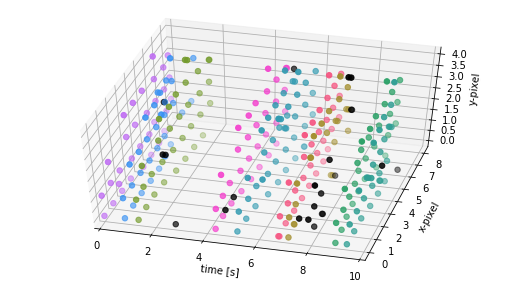

In [10]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111, projection='3d')

N = len(np.unique(clustering.labels_))
cmap = sns.husl_palette(N, h=0, l=.6)
cmap = random.sample([c for c in cmap], N)
cmap = ListedColormap([[0,0,0]]+cmap)
# cmap = plt.cm.get_cmap('hsv', len(np.unique(clustering.labels_)))
print(np.unique(clustering.labels_))

ax.scatter(evts.times[up_idx], triggers[:,0], triggers[:,1],
           c=clustering.labels_, cmap=cmap, s=30)
ax.set_xlabel('time [{}]'.format(evts.times.units.dimensionality.string))
ax.set_ylabel('x-pixel')
ax.set_zlabel('y-pixel')
ax.set_xlim((0,10))
ax.view_init(50, -75)
plt.savefig('/home/rgutzen/Sciebo/own/Presentations/2020-02-05_HBP_UseCase_pipeline/images/IDIBAPS_stage04_clustering.png')

In [134]:
a= {'b':3}
'c' in a

False